In [16]:
from matplotlib import pyplot

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [35]:
c1 = np.array([0.4, 0.3]); r1 = 0.10
c2 = np.array([0.7, 0.5]); r2 = 0.25
angles = np.linspace(0, 2 * np.pi, 30)
unitcircle = np.vstack([np.cos(angles), np.sin(angles)]).T

In [70]:
dot = np.dot

def solve_2nd_degree(a, b, c): 
    delta = b ** 2 - 4 * a * c
    if delta < 0: 
        return []
    return (
        (-b + np.sqrt(delta)) / (2 * a),
        (-b - np.sqrt(delta)) / (2 * a)
    )

def find_origin(a, b): 
    """ find one point for the line defined by a.x = b"""
    ax, ay = a
    if np.abs(ax) > np.abs(ay): 
        o = np.array([b/ax, 0])
    else: 
        o = np.array([0, b/ay])
    # print(np.dot(o, a) - b)
    return o
    
def norm2(x): 
    return np.dot(x, x)

def contact_3cricle(
        c1, r1, 
        c2, r2,
        r3): 
    """ 
    Find c3 st. (c1, r1), (c2, r2) and (c3, r3) are tangent    
    """
    b = ((r1 + r3)**2 - (r2 + r3)**2 - norm2(c1) + norm2(c2)) / 2
    a = c2 - c1 
    # a.c3 = b
    aorth = np.array([a[1], -a[0]])
    
    o = find_origin(a, b)

    # return (o, o + aorth)
        
    # c3 = o + t * aorth, find t
    oprime = o - c1
        
    ts = solve_2nd_degree(
        norm2(aorth), 
        2 * dot(oprime, aorth), 
        norm2(oprime) - (r1 + r3)**2
    )
    
    return [o + t * aorth for t in ts]


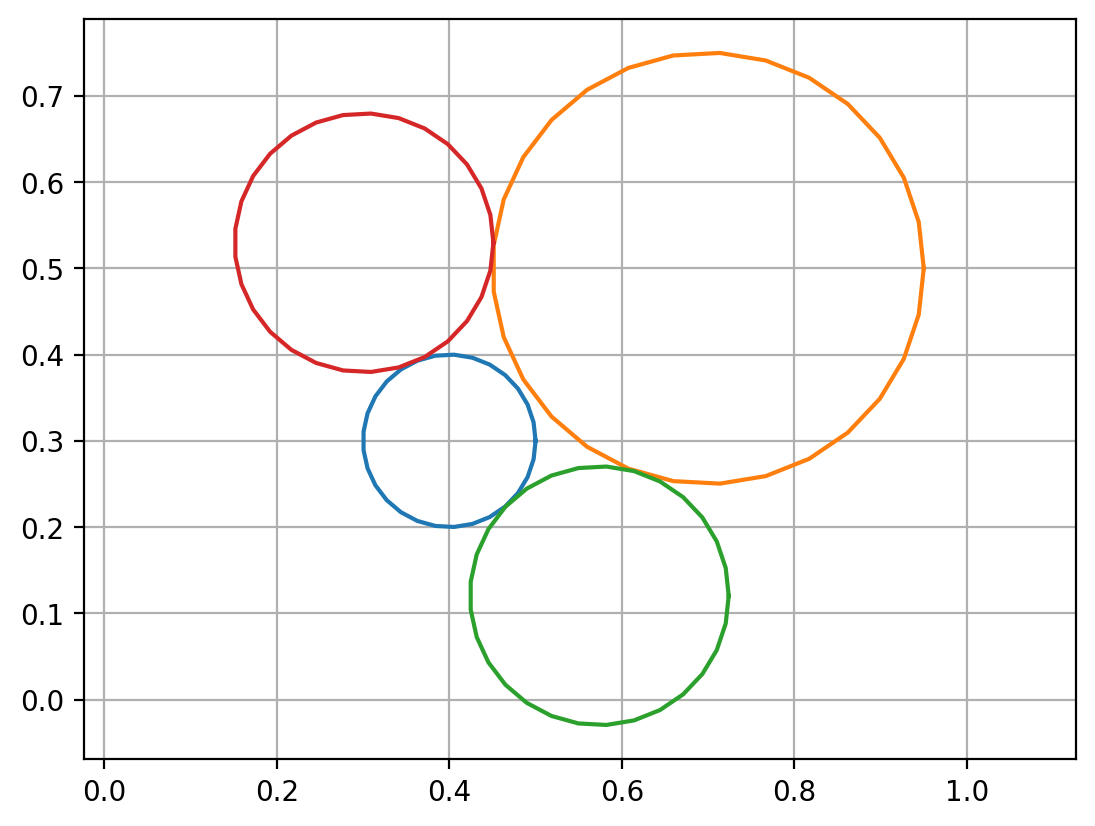

In [71]:
xy = c1 + unitcircle * r1
pyplot.plot(xy[:, 0], xy[: ,1])
xy = c2 + unitcircle * r2
pyplot.plot(xy[:, 0], xy[: ,1])


r3 = 0.15
c3s = contact_3cricle(c1, r1, c2, r2, r3)

for c3 in c3s: 
    xy = c3 + unitcircle * r3
    pyplot.plot(xy[:, 0], xy[: ,1])  

pyplot.axis("equal")
pyplot.grid()

# Field

In [95]:
# c1 = np.array([0.4, 0.3]); r1 = 0.10
# c2 = np.array([0.7, 0.5]); r2 = 0.25

c1 = np.array([0, 1]); r1 = 1
c2 = np.array([0, -1]); r2 = 1

circles = [(c1, r1), (c2, r2)]


rs = np.random.RandomState(123)
tot1 = tot2 = 0
for i in range(150): 
    r3 = rs.rand() ** 1.5 + 0.05
    nc = len(circles)
    c3s = []
    for j in range(nc):
        c1, r1 = circles[j]
        for k in range(j + 1, nc): 
            c2, r2 = circles[k]
            for c3 in contact_3cricle(c1, r1, c2, r2, r3): 
                # check if intersection with other circles 
                for l in range(nc): 
                    tot1 += 1
                    if l == k or l == j: 
                        continue
                    cl, rl = circles[l]
                    if norm2(c3 - cl) < (rl + r3) ** 2: 
                        break 
                else: 
                    c3s.append(c3)
                    tot2 += 1
    print(f"{i=:} nb c3: {len(c3s)} {tot1=:} {tot2=:}", end="\r", flush=True)
    if False: 
        # pick the c3 that has lowest y
        c3s.sort(key=lambda x: x[1])
    else: 
        # pick the c3 that is closest to 0
        c3s.sort(key=lambda x: norm2(x))
    c3 = c3s[0]
    #print(f"{c3=:}")
    circles.append((c3, r3))
    
        

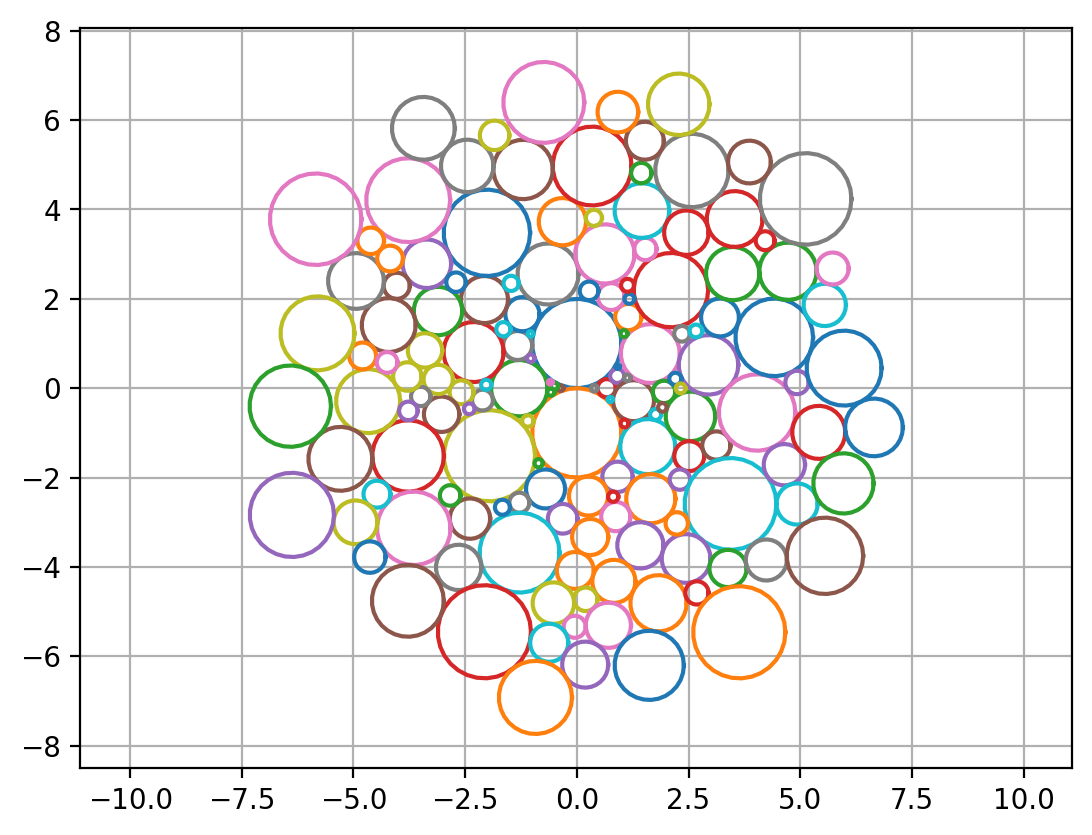

In [96]:
for c, r in circles: 
    xy = c + unitcircle * r
    pyplot.plot(xy[:, 0], xy[: ,1])  

pyplot.axis("equal")
pyplot.grid()